In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cards-image-datasetclassification/53cards-53-(200 X 200)-100.00.h5
/kaggle/input/cards-image-datasetclassification/cards.csv
/kaggle/input/cards-image-datasetclassification/14card types-14-(200 X 200)-94.61.h5
/kaggle/input/cards-image-datasetclassification/valid/ace of spades/5.jpg
/kaggle/input/cards-image-datasetclassification/valid/ace of spades/1.jpg
/kaggle/input/cards-image-datasetclassification/valid/ace of spades/4.jpg
/kaggle/input/cards-image-datasetclassification/valid/ace of spades/3.jpg
/kaggle/input/cards-image-datasetclassification/valid/ace of spades/2.jpg
/kaggle/input/cards-image-datasetclassification/valid/seven of clubs/5.jpg
/kaggle/input/cards-image-datasetclassification/valid/seven of clubs/1.jpg
/kaggle/input/cards-image-datasetclassification/valid/seven of clubs/4.jpg
/kaggle/input/cards-image-datasetclassification/valid/seven of clubs/3.jpg
/kaggle/input/cards-image-datasetclassification/valid/seven of clubs/2.jpg
/kaggle/input/cards-image-datas

In [38]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
#from tensorflow.keras.callbacks import Callback, EarlyStopping
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, Callback

In [39]:
from pathlib import Path
from tqdm import tqdm
import os

file_names = []
labels = []

for file in tqdm(sorted((Path('/kaggle/input/cards-image-datasetclassification/').glob('*/*/*.*')))):
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list
    

data_df = pd.DataFrame({"images": file_names, "labels": labels})

print(data_df.head)
data = data_df.sample(frac=1).reset_index(drop=True)
data = data[data['labels'] != 'joker']
    


100%|██████████| 8154/8154 [00:00<00:00, 327154.03it/s]

<bound method NDFrame.head of                                                  images         labels
0     /kaggle/input/cards-image-datasetclassificatio...   ace of clubs
1     /kaggle/input/cards-image-datasetclassificatio...   ace of clubs
2     /kaggle/input/cards-image-datasetclassificatio...   ace of clubs
3     /kaggle/input/cards-image-datasetclassificatio...   ace of clubs
4     /kaggle/input/cards-image-datasetclassificatio...   ace of clubs
...                                                 ...            ...
8149  /kaggle/input/cards-image-datasetclassificatio...  two of spades
8150  /kaggle/input/cards-image-datasetclassificatio...  two of spades
8151  /kaggle/input/cards-image-datasetclassificatio...  two of spades
8152  /kaggle/input/cards-image-datasetclassificatio...  two of spades
8153  /kaggle/input/cards-image-datasetclassificatio...  two of spades

[8154 rows x 2 columns]>


In [40]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(data, test_size=0.2, random_state=1)

In [41]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

class_count_train = train_df['labels'].value_counts().to_dict()
class_count_test = test_df['labels'].value_counts().to_dict()
def setup(preprocess=False):
    if preprocess:
        target_size = (100,100)

        augmented_train = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2)

        augmented_test = ImageDataGenerator(
        preprocessing_function=preprocess_input)
    else:
        target_size = (224,224)
        
        augmented_train = ImageDataGenerator(
            #rotation_range=10,
            #width_shift_range=0.1,
            #height_shift_range=0.1,
            #shear_range=0,
            #horizontal_flip=True,
            #zoom_range=0.225,
            rescale=1/255,
            validation_split=0.2)

        augmented_test = ImageDataGenerator(
            #rotation_range=10,
            #width_shift_range=0.1,
            #height_shift_range=0.1,
            #shear_range=0,
            #horizontal_flip=True,
            #zoom_range=0.225,
            rescale=1/255)
    
    train = augmented_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='labels',
    target_size=target_size,#check here
    subset="training",
    batch_size=32,
    #batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    horizontal_flip=True,
    fill_mode="nearest",
    rotation_range=30,
    #zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
)
    val = augmented_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='labels',
    target_size=target_size,#check here
    subset="validation",
    batch_size=32,
    #batch_size=16,
    class_mode='categorical',
    shuffle=False,
    seed=0,
    horizontal_flip=True,
    fill_mode="nearest",
    rotation_range=30,
    #zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    #shuffle=True
)

    test = augmented_test.flow_from_dataframe(
    dataframe=test_df,
    shuffle=False,
    x_col='images',
    y_col='labels',
    target_size=target_size,#check here
    batch_size=32,
    #batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    seed=0,
    #verbose=0,
    #chelck
)
    
    return train, val, test
train, val, test = setup()
train_1, val_1, test_1 = setup(preprocess=True)

Found 5139 validated image filenames belonging to 52 classes.
Found 1284 validated image filenames belonging to 52 classes.
Found 1606 validated image filenames belonging to 52 classes.
Found 5139 validated image filenames belonging to 52 classes.
Found 1284 validated image filenames belonging to 52 classes.
Found 1606 validated image filenames belonging to 52 classes.


In [42]:
#print(max(train.classes))
class_count = max(train.classes) + 1

In [43]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
#from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
#from tensorflow.keras.applications import MobileNetV2

model = Sequential([
    Conv2D(32, (3, 3), input_shape=(224, 224, 3)),
    #BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    #Dropout(0.2),
    
    Conv2D(64, (3, 3)),
    #BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3)),
    #BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64),
    Activation('relu'),
    Dropout(0.5),
    Dense(class_count, activation='softmax')
])

In [44]:
"""
from sklearn.utils.class_weight import compute_class_weight

classes = list(class_count_train.keys())
print(class_count_train)
y = np.concatenate([[i] * class_count_train[klass] for i, klass in enumerate(classes)])
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weight_dict = {i: weight for i, weight in enumerate(weights)}
print(weight_dict)"""

"\nfrom sklearn.utils.class_weight import compute_class_weight\n\nclasses = list(class_count_train.keys())\nprint(class_count_train)\ny = np.concatenate([[i] * class_count_train[klass] for i, klass in enumerate(classes)])\nweights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)\nweight_dict = {i: weight for i, weight in enumerate(weights)}\nprint(weight_dict)"

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),#todo, consider changing logits
              metrics=['accuracy'])
#callback commented out
callback = [EarlyStopping(monitor='val_accuracy', patience = 0.8, restore_best_weights=True)]#tweak patience
callbacks = [
        #ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
        #CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
    ] 

history = model.fit(train, epochs=10, 
validation_data=val, callbacks=callbacks)

Epoch 1/10
81/81 [==============================] - 178s 2s/step - loss: 3.8853 - accuracy: 0.0586 - val_loss: 3.3300 - val_accuracy: 0.1838 - lr: 0.0010
Epoch 2/10
81/81 [==============================] - 174s 2s/step - loss: 3.1773 - accuracy: 0.1853 - val_loss: 2.5168 - val_accuracy: 0.3660 - lr: 0.0010
Epoch 3/10
81/81 [==============================] - 174s 2s/step - loss: 2.7326 - accuracy: 0.2703 - val_loss: 2.2089 - val_accuracy: 0.4494 - lr: 0.0010
Epoch 4/10
81/81 [==============================] - 175s 2s/step - loss: 2.4036 - accuracy: 0.3508 - val_loss: 2.0187 - val_accuracy: 0.4945 - lr: 0.0010
Epoch 5/10
81/81 [==============================] - 174s 2s/step - loss: 2.1843 - accuracy: 0.3993 - val_loss: 1.8690 - val_accuracy: 0.5280 - lr: 0.0010
Epoch 6/10
81/81 [==============================] - 175s 2s/step - loss: 2.0333 - accuracy: 0.4287 - val_loss: 1.7893 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 7/10
81/81 [==============================] - 174s 2s/step - loss: 1.8

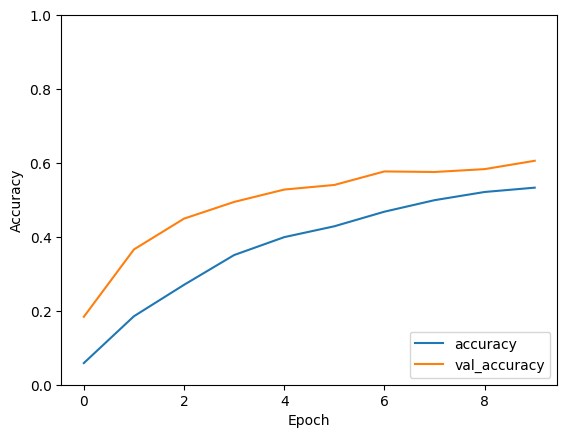

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


In [50]:
from sklearn.metrics import classification_report

def report(this_model, name):
    #test.reset()
    if name == "Liam":
        true_labels = test_df.labels
        print(true_labels)
        predictions = this_model.predict(test)
    else:
        true_labels = test_df.labels
        predictions = this_model.predict(test_1)
    predictions = np.argmax(predictions, axis=1)
    labels = (train.class_indices)
    labels = dict((i,j) for j,i in labels.items())
    pred_classes = [labels[i] for i in predictions]
    report = classification_report(true_labels, 
                                   pred_classes)
    return report

In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
#pretrained model 
mobile_model = MobileNetV2(input_shape=(100,100, 3),
                include_top=False,
                weights='imagenet',
                pooling='avg')
mobile_model.trainable = False
inputs = mobile_model.input
x = Dense(64, activation='relu')(mobile_model.output)
x = Dense(64, activation='relu')(x)
outputs = Dense(5, activation='softmax')(x)
mobile = Model(inputs=inputs, outputs=outputs)
mobile.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
"""
callback  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]
                              """
callbacks = [
        #ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
        #CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
    ] 
history = mobile.fit(train_1, validation_data=val_1, epochs=100,callbacks=callbacks,verbose=1, class_weight=weight_dict);

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5: None -- [Errno -3] Temporary failure in name resolution

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Mobile-Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [51]:
report(model, "Liam")

3018       two of hearts
430         two of clubs
104     five of diamonds
3257     eight of spades
1715     seven of spades
              ...       
1467       six of hearts
7747      five of hearts
5067      queen of clubs
8084        two of clubs
5315       two of hearts
Name: labels, Length: 1606, dtype: object
26/26 [==============================] - 16s 606ms/step


'                   precision    recall  f1-score   support\n\n     ace of clubs       0.66      0.77      0.71        30\n  ace of diamonds       0.76      0.69      0.72        32\n    ace of hearts       0.67      0.72      0.69        39\n    ace of spades       0.64      0.95      0.76        41\n   eight of clubs       0.74      0.57      0.65        40\neight of diamonds       0.50      0.57      0.53        30\n  eight of hearts       0.59      0.50      0.54        34\n  eight of spades       0.50      0.38      0.43        29\n    five of clubs       0.59      0.68      0.63        28\n five of diamonds       0.75      0.58      0.65        31\n   five of hearts       0.71      0.67      0.69        33\n   five of spades       0.85      0.85      0.85        27\n    four of clubs       0.77      0.77      0.77        22\n four of diamonds       0.78      0.50      0.61        28\n   four of hearts       0.55      0.63      0.59        27\n   four of spades       0.74      0.6

In [ ]:
print("_______________Liams Model__________________")
print(report(model, "Liam"))
print("_______________Mobile Net___________________")
print(report(mobile, "Mobile"))